In [15]:
import operator
import uuid
from datetime import datetime
from typing import Annotated, Dict, List, Literal, Optional, Union

import nest_asyncio
import re
import requests
import xml.etree.ElementTree as ET
from langchain import hub
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.memory import ConversationBufferMemory
from langchain.tools.retriever import create_retriever_tool
from langchain_chroma import Chroma
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.document_loaders import SeleniumURLLoader, SitemapLoader
from langchain_community.document_loaders.base import BaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import ensure_config, Runnable, RunnableConfig, RunnableLambda, RunnablePassthrough
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from seleniumbase import Driver
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, START, MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent, ToolNode, tools_condition
from dotenv import load_dotenv

load_dotenv()
nest_asyncio.apply()

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [11]:
# Utils
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def get_customer_id_from_config() -> Union:
    config = ensure_config()
    configuration = config.get("configurable", {})
    try:
        return configuration["customer_id"]
    except KeyError:
        raise ValueError("Process must be invoked with a customer ID")


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def get_new_invoice_id():
    invoice_id = db._execute(
        "select max(InvoiceId) as max_invoice_id from invoices"
    )[0]['max_invoice_id']
    return invoice_id + 1


In [16]:
# Create own selenium url loader using seleniumbase (bypassing Cloudflare)
class MySeleniumURLLoader(BaseLoader):
    def __init__(
        self,
        urls: List[str],
        continue_on_failure: bool = True,
        binary_location: Optional[str] = None,
        executable_path: Optional[str] = None,
        headless: bool = True,
        arguments: Dict = None,
    ):
        """Load a list of URLs using Selenium and unstructured."""
        try:
            from seleniumbase import Driver  # noqa:F401
        except ImportError:
            raise ImportError(
                "seleniumbase package not found, please install it with "
                "`pip install seleniumbase`"
            )

        self.urls = urls
        self.continue_on_failure = continue_on_failure
        self.binary_location = binary_location
        self.executable_path = executable_path
        self.headless = headless
        self.arguments = arguments

    def _get_driver(self) -> Union["Chrome", "Firefox"]:
        """Create and return a WebDriver instance based on the specified browser.

        Raises:
            ValueError: If an invalid browser is specified.

        Returns:
            Union[Chrome, Firefox]: A WebDriver instance for the specified browser.
        """
        kwargs = {
            "headless": self.headless,
        }
        if self.arguments:
            kwargs.update(self.arguments)

        return Driver(uc=True, **kwargs)

    def _get_page_content(self, driver: Union["Chrome", "Firefox"]) -> str:
        """Build page content based on the contents of the webpage"""
        try:
            if element := driver.find_element(
                By.CLASS_NAME, 'article-body'
            ):
                page_content = driver.title + '\n\n' + element.text
        except NoSuchElementException:
            page_content = None
        return page_content

    def _build_metadata(self, url: str, driver: Union["Chrome", "Firefox"]) -> dict:
        from selenium.common.exceptions import NoSuchElementException
        from selenium.webdriver.common.by import By

        """Build metadata based on the contents of the webpage"""
        metadata = {
            "source": url,
            "title": "No title found.",
            "description": "No description found.",
            "language": "No language found.",
        }
        if title := driver.title:
            metadata["title"] = title
        try:
            if description := driver.find_element(
                By.XPATH, '//meta[@property="og:description"]'
            ):
                metadata["description"] = (
                    description.get_attribute("content") or "No description found."
                )
        except NoSuchElementException:
            pass
        try:
            if html_tag := driver.find_element(By.TAG_NAME, "html"):
                metadata["language"] = (
                    html_tag.get_attribute("lang") or "No language found."
                )
        except NoSuchElementException:
            pass
        return metadata

    def load(self) -> List[Document]:
        """Load the specified URLs using Selenium and create Document instances.

        Returns:
            List[Document]: A list of Document instances with loaded content.
        """
        docs: List[Document] = list()
        driver = self._get_driver()

        for url in self.urls:
            try:
                driver.get(url)
                metadata = self._build_metadata(url, driver)
                page_content = self._get_page_content(driver) or metadata["description"]
                docs.append(Document(page_content=page_content, metadata=metadata))
            except Exception as e:
                if self.continue_on_failure:
                    logger.error(f"Error fetching or processing {url}, exception: {e}")
                else:
                    raise e

        driver.quit()
        return docs


In [13]:
# Retrieve relevant URLs
r = requests.get("https://help.reverb.com/hc/sitemap.xml")
xml_text = r.text
root = ET.fromstring(xml_text)
namespace = {'ns': 'http://www.sitemaps.org/schemas/sitemap/0.9'}
loc_elements = root.findall('.//ns:loc', namespace)
pattern = re.compile(r'https:\/\/help\.reverb\.com\/hc\/en-us\/[^\s]*')
urls = [loc.text for loc in loc_elements if pattern.match(loc.text)]

In [17]:
# Create a loader using Selenium (SitemapLoader doesn't work here because of javascript requirements)
loader = MySeleniumURLLoader(urls=urls)
docs = loader.load()

In [22]:
embeddings = OpenAIEmbeddings()
chroma_db = Chroma.from_documents(docs, embeddings)

In [23]:
llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)

In [24]:
# Interact with the Chinook db
db = SQLDatabase.from_uri("sqlite:///chinook.db")

In [25]:
# Tool used to retrieve data from the database for a specific customer ID
@tool
def get_customer_info(query: str):
    """
    Get information from the application database for the customer.
    This tool should not be used for a general understanding of what exists in
    our store.  This is only used when the customer is looking to understand
    their purchase history, what they listen to, and other things that pertain
    to their customer ID.

    Note: This tool is only used to retrieve data.  Never used to update, insert, or
    delete data from the database.  Also, it should always be scoped down to a
    single customer_id, which is retrieved from the configuration.

    Never let the user specify a customer ID.
    """
    customer_id = get_customer_id_from_config()
    suffix = f"""
    All SQL queries need to be filtered down to a single customer.
    That customer is: {customer_id}
    {customer_id} is a CustomerId, which is a field in the customers table.
    So, you'll need to ensure that your SQL queries contain a WHERE clause with at least this:
    `CustomerId = {customer_id}`
    If that means you need to join to the Customers table, then you need to do that.
    """
    agent_executor = create_sql_agent(
        llm,
        db=db,
        suffix=suffix,
        agent_type="tool-calling",
        handle_parsing_error=True,
    )
    return agent_executor.invoke({"input": query})


In [27]:
# Music Agent
artists = db._execute("select * from artists")
songs = db._execute("select * from tracks")
artist_retriever = SKLearnVectorStore.from_texts(
    [a["Name"] for a in artists],
    OpenAIEmbeddings(),
    metadatas=artists
).as_retriever()
song_retriever = SKLearnVectorStore.from_texts(
    [s["Name"] for s in songs],
    OpenAIEmbeddings(),
    metadatas=songs,
).as_retriever()

In [28]:
# Tools used by Music Agent

@tool
def get_artist(artist_name: str):
    """In our database, get an artist (or similar)."""
    docs = artist_retriever.get_relevant_documents(artist_name)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"""
            SELECT
                ArtistId,
                Name as ArtistName
            FROM artists
            WHERE ArtistId in ({artist_ids});
        """,
        include_columns=True
    )

@tool
def get_albums_by_artist(artist_name: str):
    """In our database, get albums by an artist (or similar artists)."""
    docs = artist_retriever.get_relevant_documents(artist_name)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"""
            SELECT
                AlbumId,
                Title,
                Name
            FROM albums
            LEFT JOIN artists ON
                albums.ArtistId = artists.ArtistId
            WHERE albums.ArtistId in ({artist_ids});
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist_name: str):
    """In our database, get songs by an artist (or similar artists)."""
    docs = artist_retriever.get_relevant_documents(artist_name)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"""
            SELECT
                tracks.TrackId,
                tracks.Name as SongName,
                artists.Name as ArtistName
            FROM albums
            LEFT JOIN artists ON
                albums.ArtistId = artists.ArtistId
            LEFT JOIN tracks ON
                tracks.AlbumId = albums.AlbumId
            WHERE albums.ArtistId in ({artist_ids});
        """,
        include_columns=True,
    )

@tool
def check_if_song_exists(song_title: str):
    """In our database, check if a song exists by its name."""
    return song_retriever.get_relevant_documents(song_title)

In [29]:
# Tool used to issue refunds
@tool
def give_customer_refund(invoice_line_ids: List[int]):
    """
    Issue a customer refund for specific invoice lines.
    Invoice lines relate to individual tracks purchased in an invoice.
    """

    new_invoice_id = get_new_invoice_id()

    # Create new invoice with refund
    customer_id = get_customer_id_from_config()
    today_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    invoice_line_ids_str = ','.join([str(i) for i in invoice_line_ids])
    sql = f"""
    insert into invoices (InvoiceId, CustomerId, InvoiceDate, BillingAddress, BillingCity, BillingState, BillingCountry, BillingPostalCode, Total)
    select
        {new_invoice_id},
        {customer_id},
        '{today_date}',
        i.BillingAddress,
        i.BillingCity,
        i.BillingState,
        i.BillingCountry,
        i.BillingPostalCode,
        sum(ii.UnitPrice) * -1 as Total
    from invoice_items as ii
    join invoices as i on
        ii.InvoiceId = i.InvoiceId
    where ii.InvoiceLineId in ({invoice_line_ids_str})
    group by 1, 2, 3, 4, 5, 6, 7, 8
    """
    return db._execute(sql)

@tool
def buy_tracks(track_ids: List[int]):
    """
    Allow customer to purchase net new tracks for their account.
    """

    new_invoice_id = get_new_invoice_id()    
    customer_id = get_customer_id_from_config()
    today_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    track_ids_str = ','.join([str(i) for i in track_ids])

    # Create new invoice for purchasing
    sql = f"""
    insert into invoices (InvoiceId, CustomerId, InvoiceDate, BillingAddress, BillingCity, BillingState, BillingCountry, BillingPostalCode, Total)
    select
        {new_invoice_id},
        {customer_id},
        '{today_date}',
        Address,
        City,
        State,
        Country,
        PostalCode,
        (select sum(UnitPrice) as total from tracks where TrackId in ({track_ids_str})) as Total
    from customers
    where CustomerId = {customer_id};
    """
    # TODO: Create InvoiceItems for each track_id
    return db._execute(sql)
    


In [30]:
retriever = chroma_db.as_retriever(search_type="mmr")

company_help_retriever_tool = create_retriever_tool(
    retriever,
    "company_help_and_faq",
    """
    Used only to assist in support-type questions.  For example:
    - What is your refund policy?
    - How late are you open?
    - How can I become a seller?

    Note: You're not able to get anything related to what the company sells.
    """,
)

In [31]:
# Create my customer support assistant
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: AgentState, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

customer_support_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for a music store.  "
            "Use the provided tools to retrieve customer information, company "
            "policies, general music inquiries, and other information to assist the user's queries.  "
            "If a search comes up empty, expand your search before giving up.  "
            "When retrieving customer info, you will not need to ask the user "
            "additional information, it will already be available to you.  "
            "Ensure your responses are very succinct and any mention of 'Reverb' "
            "should be switched to `Chinook`."
            "When pulling data from the database, never indicate that we are filtering "
            "by a specific CustomerId."
            "When asking the user if they want to purchase or refund anything and you present them "
            "with a numbered list and they respond with numbers - this does not represent IDs within "
            "the database.  It simply represents how you numbered the list.  Again, do not use the "
            "numbers in the list as IDs.  You will be able to see the IDs retrieved from the respective "
            "tools, so use those anytime an ID is needed by a tool."
        ),
        ("placeholder", "{messages}"),
    ]
)

tools = [
    get_customer_info,
    TavilySearchResults(max_results=1),
    company_help_retriever_tool,
    get_artist,
    get_albums_by_artist,
    get_tracks_by_artist,
    check_if_song_exists
]
tools_names = {t.name for t in tools}
interrupt_tools = [give_customer_refund, buy_tracks]
assistant_runnable = customer_support_assistant_prompt | llm.bind_tools(tools + interrupt_tools)

In [32]:
def route_tools(state: AgentState) -> Literal["tools", "interrupt_tools", "__end__"]:
    next_node = tools_condition(state)
    if next_node == END:
        return END

    ai_message = state["messages"][-1]
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in tools_names:
        return "tools"

    return "interrupt_tools"
    
builder = StateGraph(AgentState)

builder.add_node("assistant", Assistant(assistant_runnable))
builder.set_entry_point("assistant")
builder.add_node("tools", create_tool_node_with_fallback(tools))
builder.add_node("interrupt_tools", create_tool_node_with_fallback(interrupt_tools))
builder.add_conditional_edges("assistant", route_tools)
builder.add_edge("tools", "assistant")
builder.add_edge("interrupt_tools", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory, interrupt_before=["interrupt_tools"])

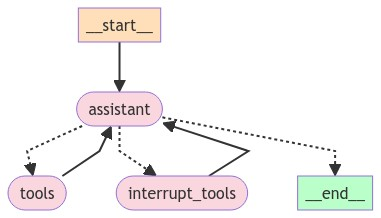

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "customer_id": 5,
        "thread_id": thread_id
    },
}

In [38]:
_printed = set()
history = []
while True:
    user = input('User (q/Q to quit): ')
    if user in {'q', 'Q'}:
        print('AI: Byebye')
        break
    history.append(HumanMessage(content=user))
    for event in graph.stream({"messages": history}, config, stream_mode="values"):
        _print_event(event, _printed)
    snapshot = graph.get_state(config)
    while snapshot.next:
        user_input = input(
            "Are you sure you want to proceed?  Type 'y' "
            "to proceed with the refund; otherwise, the request will be cancelled."
        )
        if user_input.strip() == "y":
            graph.invoke(None, config)
        else:
            graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"Refund denied by user.  Continue assisting the user.",
                        )
                    ]
                },
                config,
            )
        snapshot = graph.get_state(config)
        for event in graph.stream({"messages": history}, config, stream_mode="values"):
            _print_event(event, _printed)

User (q/Q to quit):  what did i ask you last?


================================ Human Message =================================

what did i ask you last?
================================== Ai Message ==================================

You asked how much you have spent.


User (q/Q to quit):  and how much was that?


================================ Human Message =================================

and how much was that?
================================== Ai Message ==================================

You have spent a total of $39.62.


User (q/Q to quit):  what was the question I asked right before that


================================ Human Message =================================

what was the question I asked right before that
================================== Ai Message ==================================

You asked how many tracks you have purchased.


User (q/Q to quit):  and how many was that?


================================ Human Message =================================

and how many was that?
================================== Ai Message ==================================

You have purchased a total of 38 tracks.


User (q/Q to quit):  i love how you can remember everything!


================================ Human Message =================================

i love how you can remember everything!
================================== Ai Message ==================================

Thank you! I'm here to help. Is there anything else you need assistance with?


User (q/Q to quit):  Nope


================================ Human Message =================================

Nope
================================== Ai Message ==================================

Alright, have a great day! If you need anything else, feel free to reach out.


User (q/Q to quit):  q


AI: Byebye
